In [103]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import json

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from random import random
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [104]:
MAX_SENT_SIZE = 20

In [105]:
from torch.utils.data import Dataset
from PIL import Image
import json
import pandas as pd

class COCODataset(Dataset):
    def __init__(self, root, annotation_path, train=True, transform_image=None, transform_text=None, filter_df=None, take_first=None):
        data = json.load(open(annotation_path))
        self.root = root
        self.annotation_path = annotation_path
        self.transform_image = transform_image
        self.transform_text = transform_text
        self.train = train
        
        # get images
        images = {
            'file_name': [],
            'height': [],
            'width': [],
            'image_id': [],
        }

        for image in data['images']:
            images['file_name'].append(image['file_name'])
            images['height'].append(image['height'])
            images['width'].append(image['width'])
            images['image_id'].append(image['id'])
        images = pd.DataFrame(images)
        
        if train:
            # get annotations
            annotations = {
                'image_id': [],
                'id': [],
                'caption': [],
            }

            for annotation in data['annotations']:
                annotations['image_id'].append(annotation['image_id'])
                annotations['id'].append(annotation['id'])
                annotations['caption'].append(annotation['caption'])
            annotations = pd.DataFrame(annotations)
        
        if train:
            # merge images and annotations
            self.df = annotations.merge(images, on='image_id')
        else:
            self.df = images
        
        # free memory
        del images, annotations, data
        
        if filter_df is not None:
            self.df = filter_df(self.df)

        if take_first is not None:
            self.df = self.df[:take_first]
        
        self.df = self.df.reset_index(drop=True)
            
    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        image = self._load_image(file_name)
        
        if self.transform_image is not None:
            image = self.transform_image(image)
        
        if self.train:
            caption = self.df['caption'][idx]
            if self.transform_text:
                caption = self.transform_text(caption)
            
            return image, caption
        
        return image
    
    def __len__(self):
        return len(self.df)
    
    def _load_image(self, file_name):
        return Image.open(self.root + "/" + file_name).convert('RGB')
    

def preprocess_text(text: str) -> list[str]:
    text = text.lower()
    return word_tokenize(text)


def filter_df(df, max_sent_size=MAX_SENT_SIZE, max_height=800, max_width=800, min_height=200, min_width=200):
    df = df[df['caption'].apply(word_tokenize).apply(len) <= MAX_SENT_SIZE-2] # <sos>, <eos>
    
    df = df[(df['height'] <= max_height) & (df['height'] >= min_height)]
    df = df[(df['width'] >= min_width) & (df['width'] <= max_width)]
        
    return df

In [106]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

image_size = (224, 224)
transforms = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [107]:
train_dataset = COCODataset(
    root='/kaggle/input/coco-2017-dataset/coco2017/train2017',
    annotation_path='/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json',
    train=True,
    transform_image=transforms,
    transform_text=preprocess_text,
    filter_df=filter_df,
    take_first=100_000,
)

val_dataset = COCODataset(
    root='/kaggle/input/coco-2017-dataset/coco2017/val2017',
    annotation_path='/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json',
    train=True,
    transform_image=transforms,
    transform_text=preprocess_text,
    filter_df=filter_df,
    take_first=10_000,
)

In [108]:
len(train_dataset), len(val_dataset)

(100000, 10000)

['two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street']

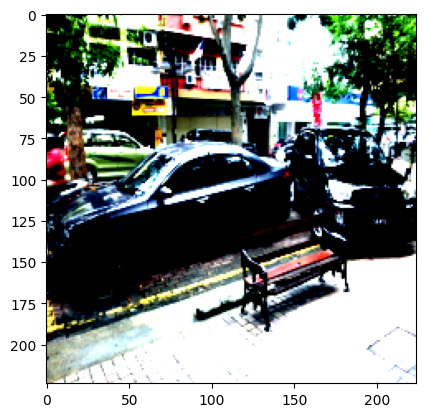

In [109]:
image, caption = train_dataset[11]
plt.imshow(image.permute(1, 2, 0))
caption

# Let's create vocab for captions

In [110]:
MAX_TOKENS = 20_000

In [111]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(df):
    for i in df.index:
        captions = df['caption'][i]
        yield word_tokenize(captions)
    
vocab = build_vocab_from_iterator(
    yield_tokens(train_dataset.df),
    min_freq=2,
    specials=['<unk>', '<pad>', '<sos>', '<eos>'],
    max_tokens=MAX_TOKENS,
)
vocab.set_default_index(0)

In [112]:
len(vocab)

9038

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [114]:
batch_size = 32

In [115]:
def collate_batch(batch):
    images = []
    captions = []
    for image, caption in batch:
        images.append(image)
        caption = ['<sos>'] + caption[:MAX_SENT_SIZE-2] + ['<eos>']
        caption = vocab.lookup_indices(caption)
        while len(caption) < MAX_SENT_SIZE:
            caption.append(vocab['<pad>'])
            
        captions.append(torch.tensor(caption))
    
    images = torch.stack(images, dim=0).to(device)
    captions = torch.stack(captions, dim=0).to(device)
    # images.shape: [batch_size, num_channels, height, width]
    # captions.shape: [batch_size, max_sent_size]
    
    return images, captions

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [116]:
for images, captions in train_dataloader:
    print("images.shape:", images.shape)
    print("captions.shape:", captions.shape)
    break

images.shape: torch.Size([32, 3, 224, 224])
captions.shape: torch.Size([32, 20])


In [117]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
    
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, dropout=0.3):
        super(Encoder, self).__init__()
        
        self.model = models.resnet50(weights='DEFAULT', progress=False)
        
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(dropout),
            
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            
            nn.Linear(512, hidden_dim),
        )
        self.freeze()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def _req_grad(self, b):
        for name, params in self.named_parameters():
            if name.find('fc') != -1:
                break
            params.requires_grad = b
    
    def freeze(self):
        self._req_grad(False)
    
    def unfreeze(self):
        self._req_grad(True)


class FeedForward(nn.Module):
    """
        Linear layer after non-linearity
    """
    def __init__(self, n_embd):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_embd, n_embd * 4),
            nn.ReLU(),
            nn.Linear(n_embd * 4, n_embd)
        )
    
    def forward(self, data):
        return self.model(data)


class AttentionHead(nn.Module):
    """
        Attention head of heads
    """
    def __init__(self, embed_size, head_size, batch_size, mask=False, dropout=0.2):
        super().__init__()
        self.mask = mask
        
        self.query = nn.Linear(embed_size, head_size)
        self.key = nn.Linear(embed_size, head_size)
        self.value = nn.Linear(embed_size, head_size)
        if mask:
            self.register_buffer('tril', torch.tril(torch.ones(batch_size, batch_size)))
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, data, crossData=None):
        """
            :param crossData: 
                * crossData = None -> It's Self Attention
                * else             -> It's Cross Attention
                
                
            B -> batch size
            T -> series length
            C -> size of embedding
        """
        B,T,C = data.shape
        query = self.query(data)
        if crossData is not None:
            key = self.key(crossData)
            v = self.value(crossData)
        else:
            key = self.key(data)
            v = self.value(data)
        
        wei = query @ key.transpose(1, 2) #* C**-0.5 # # (B, 1, C) @ (B, C, T) -> (B, 1, T)
        if self.mask:
            wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        out = wei @ v # (B, 1, T) @ (B, T, C) -> (B, 1, C)
        return out
        
        
class MultipleAttention(nn.Module):
    """
        Multiple head for Attention
    """
    def __init__(self, embed_size, n_head, head_size, batch_size, mask=False, dropout=0.2):
        super().__init__()
        self.blockHead = nn.Sequential(*[AttentionHead(embed_size, head_size, batch_size, mask, dropout) for _ in range(n_head)])
        self.fc = nn.Linear(head_size * n_head, embed_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, data, crossData=None):
        heads = torch.cat([layer(data, crossData=crossData) for layer in self.blockHead], dim=-1)
        
        out = self.dropout(self.fc(heads))
        return out

        
class AttentionBlock(nn.Module):
    """
        Attention Block
    """
    def __init__(self, embed_size, n_head, batch_size, mask=False, dropout=0.2):
        super().__init__()
        head_size = embed_size // n_head
        self.sa = MultipleAttention(embed_size, n_head, head_size, batch_size, mask, dropout)
        self.ffwd = FeedForward(embed_size)
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
        
        
    def forward(self, data, crossData=None):
        data = data + self.sa(self.ln1(data), crossData=crossData)
        data = data + self.ffwd(self.ln2(data))
        return data

    
class Decoder(nn.Module):
    def __init__(self, n_head, n_layer, batch_size, max_length, output_dim, embed_dim, hidden_dim, vocab, dropout, padding_idx, device):
        super(Decoder, self).__init__()
        self.device = device
        self.token_embed = nn.Embedding(output_dim, embed_dim, padding_idx)
        self.position_embed = nn.Embedding(max_length, embed_dim, padding_idx)
        self.output_dim = output_dim
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.self_blocks = nn.Sequential(*[AttentionBlock(embed_dim, n_head, batch_size, mask=True) for _ in range(n_layer)])
        self.cros_blocks = nn.Sequential(*[AttentionBlock(embed_dim, n_head, batch_size) for _ in range(n_layer)])
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden):
        B, T = x.shape
        tok_emb = self.dropout(self.token_embed(x))
        pos_emb = self.position_embed(torch.arange(T, device=self.device))
        x = tok_emb + pos_emb
        x = self.self_blocks(x)
        
        query = hidden.unsqueeze(1)
        for layer in self.cros_blocks:
            x = layer(x, query)
        
        out = self.fc_out(x)
        return out

In [118]:
import torch.nn as nn
import torch
from random import random



class Attention(nn.Module):
    def __init__(self, encoder, decoder, max_sent_size, device):
        super(Attention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_sent_size = max_sent_size
        self.device = device
        
    def forward(self, image_features, captions, teacher_force_ratio=0.5):
        batch_size, max_sent_size = captions.shape
        enc_outputs = self.encoder(image_features)
        vocab = self.decoder.vocab
        output_dim = self.decoder.output_dim
        out = self.decoder(captions, enc_outputs)
        return out
    
    def predict(self, image, transform_image):
        self.eval()
        image = transform_image(image).to(self.device).unsqueeze(0)
        with torch.no_grad():
            enc_outputs = self.encoder(image)
        vocab = self.decoder.vocab
        res = [vocab['<sos>']]
        hidden = enc_outputs.unsqueeze(0)
        eos_idx = vocab['<eos>']
        with torch.no_grad():
            for t in range(self.max_sent_size):
                dec_input = torch.LongTensor(res).to(self.device).unsqueeze(0)
                preds = self.decoder(dec_input, enc_outputs) # (1, t, vocab_size)
                logits = preds[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
                res.append(idx_next[0].cpu().detach().numpy()[0])
        
        res = vocab.lookup_tokens(res[1:])
        
        return res

In [119]:
from tqdm import tqdm
import torch

def train_epoch(
    model,
    train_dataloader,
    loss_fn,
    optimizer,
    epoch=None,
    clip=None,
):
    loop = tqdm(
        enumerate(train_dataloader),
        total=len(train_dataloader),
        desc=f"Training: {'' if epoch is None else epoch}"
    )
    model.train()
    total_loss = 0
    for i, (images, captions) in loop:
        optimizer.zero_grad()
        
        preds = model(images, captions[:, :-1])
        
        # captions.shape: [batch_size, sent_size]
        # preds.shape: [batch_size, max_sent_size, output_dim]
        output_dim = model.decoder.output_dim
        preds = preds.reshape(-1, output_dim)
        captions = captions[:, 1:].reshape(-1)

        loss = loss_fn(preds, captions)
        
        loss.backward()
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(**{'loss': total_loss / (i + 1)})
    return total_loss / len(train_dataloader)
        
def eval_epoch(
    model,
    val_dataloader,
    loss_fn,
    epoch=None,
):
    loop = tqdm(
        enumerate(val_dataloader),
        total=len(val_dataloader),
        desc=f"Validation: {'' if epoch is None else epoch}"
    )
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (images, captions) in loop:
            preds = model(images, captions[:, :-1])

            # captions.shape: [batch_size, sent_size]
            # preds.shape: [batch_size, max_sent_size, output_dim]
            output_dim = model.decoder.output_dim
            preds = preds.reshape(-1, output_dim)
            captions = captions[:, 1:].reshape(-1)

            loss = loss_fn(preds, captions)

            total_loss += loss.item()
            loop.set_postfix(**{'loss': total_loss / (i + 1)})
            
    return total_loss / len(val_dataloader)

def train(
    model,
    epochs,
    dataloaders,
    loss_fn,
    optimizer,
    grad_clip,
    ckpt_path='best.pt',
    best_so_far=float('inf'),
):
    for epoch in range(1, epochs+1):
        train_loss = train_epoch(model, dataloaders[0], loss_fn, optimizer, epoch, grad_clip)
        if len(dataloaders) > 1:
            val_loss = eval_epoch(model, dataloaders[1], loss_fn, epoch)
        else:
            val_loss = train_loss
        
        if val_loss < best_so_far:
            best_so_far = val_loss
            torch.save(model.state_dict(), ckpt_path)
        
    return best_so_far

In [120]:
# model parameters
input_channels = 3
output_dim = len(vocab)
dropout = 0.3
embed_dim = 256
hidden_dim = 256
num_layers = 2
padding_idx = vocab['<pad>']
n_head = 8
n_layer = 1
batch_size = 32
max_length=MAX_SENT_SIZE

In [121]:
encoder = Encoder(
    input_channels,
    hidden_dim,
    dropout,
).to(device)

decoder = Decoder(
    n_head,
    n_layer,
    batch_size,
    max_length,
    output_dim,
    embed_dim,
    hidden_dim,
    vocab,
    dropout,
    padding_idx,
    device
).to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [122]:
best_so_far = float('inf')
model = Attention(encoder, decoder, MAX_SENT_SIZE, device).to(device)
model.encoder.unfreeze()

In [123]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_idx)

In [124]:
best_so_far = train(
    model=model,
    epochs=5,
    dataloaders=(train_dataloader, val_dataloader),
    loss_fn=loss_fn,
    optimizer=optimizer,
    grad_clip=1,
    best_so_far=best_so_far,
)

Validation: 5: 100%|██████████| 313/313 [01:36<00:00,  3.24it/s, loss=2.65]


In [126]:
def predict(model, image, transform_image):
    model.eval()
    image = transform_image(image).to(model.device).unsqueeze(0)
    with torch.no_grad():
        enc_outputs = model.encoder(image)
    vocab = model.decoder.vocab
    res = [vocab['<sos>']]
    hidden = enc_outputs.unsqueeze(0)
    eos_idx = vocab['<eos>']
    with torch.no_grad():
        for t in range(model.max_sent_size):
            dec_input = torch.LongTensor(res).to(model.device).unsqueeze(0)
            preds = model.decoder(dec_input, enc_outputs) # (1, t, vocab_size)
            logits = preds[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = probs.argmax(-1) # (B)
            #idx_next = torch.multinomial(probs, num_samples=1)
            if idx_next[0] == eos_idx:
                break
            res.append(idx_next[0].cpu().detach().numpy())

    res = vocab.lookup_tokens(res[1:])

    return res
    model.eval()
    image = transform_image(image).to(device).unsqueeze(0)
    with torch.no_grad():
        enc_outputs = model.encoder(image)
    vocab = model.decoder.vocab
    res = [vocab['<sos>']]
    hidden = enc_outputs.unsqueeze(0)
    eos_idx = vocab['<eos>']
    with torch.no_grad():
        for t in range(model.max_sent_size):
            dec_input = torch.LongTensor([res[-1]]).to(device).unsqueeze(0)

            preds, hidden = model.decoder(dec_input, hidden)

            top1 = preds.argmax(-1)

            if top1 == eos_idx:
                break
            res.append(top1.cpu().detach().numpy()[0])
    
    res = vocab.lookup_tokens(res[1:])
    
    return res

# Let's see the results

['a',
 'giraffe',
 'standing',
 'next',
 'to',
 'a',
 'tree',
 'in',
 'a',
 'field',
 '.']

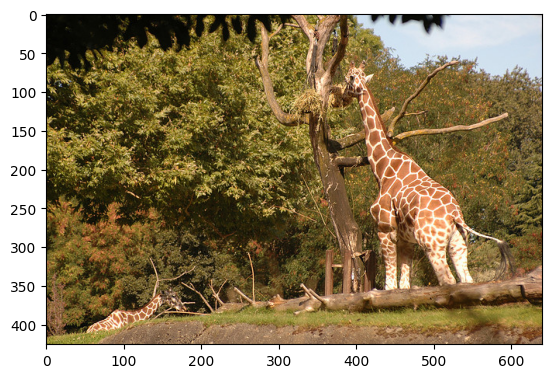

In [127]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000025.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'dog', 'sitting', 'on', 'a', 'sidewalk', 'next', 'to', 'a', 'bike', '.']

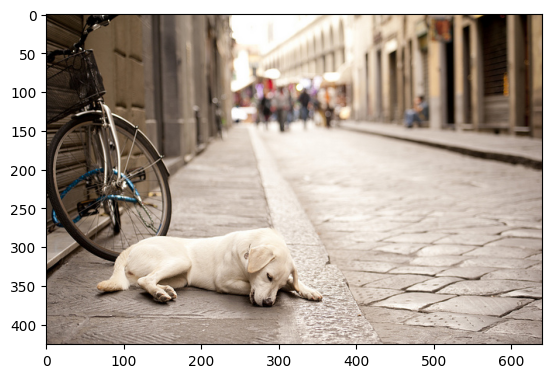

In [128]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000074.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'group', 'of', 'people', 'sitting', 'on', 'a', 'bench', '.']

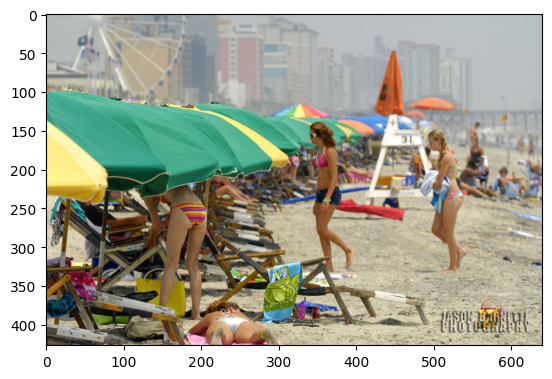

In [129]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000315.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'skiing',
 'gear',
 'down',
 'a',
 'mountain',
 '.']

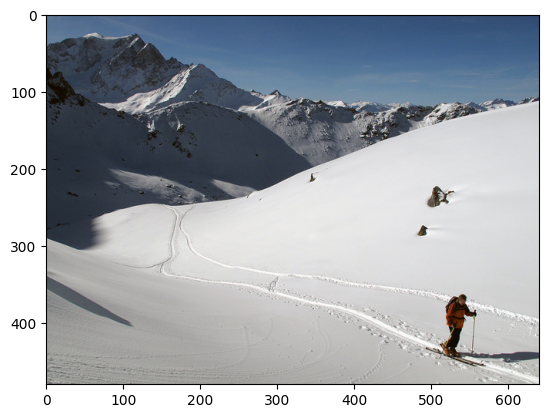

In [131]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000382.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a',
 'bathroom',
 'with',
 'a',
 'sink',
 ',',
 'mirror',
 ',',
 'mirror',
 ',',
 'and',
 'a',
 'toilet',
 '.']

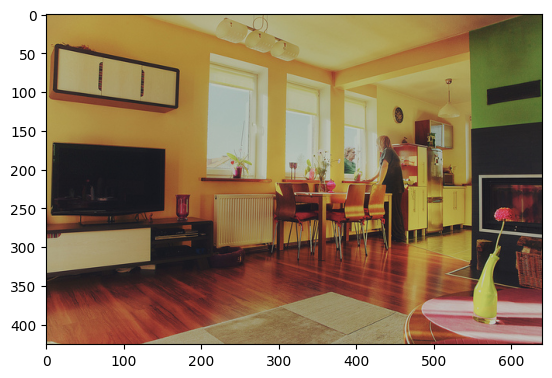

In [134]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000139.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'dog', 'laying', 'on', 'top', 'of', 'a', 'pile', 'of', 'hay', '.']

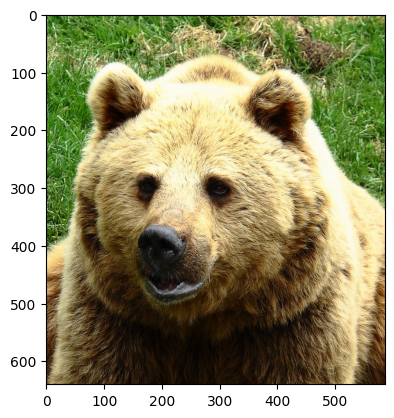

In [136]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000285.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'stop', 'sign', 'that', 'is', 'on', 'a', 'pole', '.']

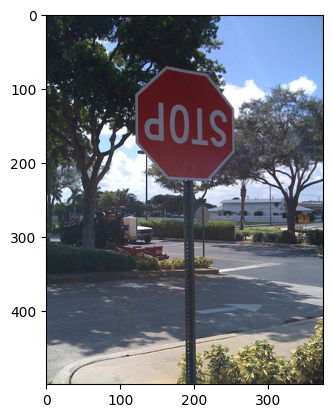

In [137]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000724.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a',
 'group',
 'of',
 'people',
 'standing',
 'around',
 'a',
 'wooden',
 'bench',
 '.']

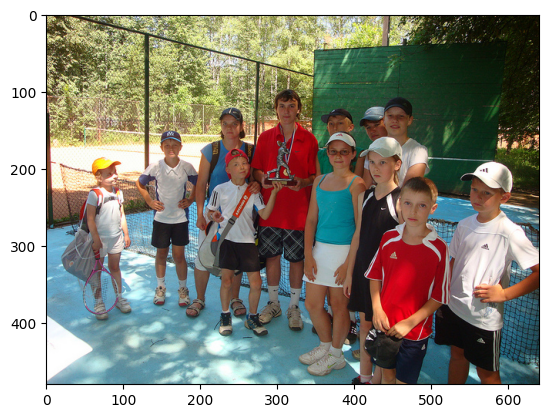

In [138]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/val2017/000000001000.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

# As we can see from the pictures above, the model describe what happened in the picture almost perfectly. 